In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import math
import warnings
from datetime import datetime

# FutureWarning 제거
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# 2016년 ~ 2024년 9월까지의 데이터를 미리 저장해두고 선택한 기간만큼 추출 : 보조지표 계산을 위함
# 백테스트 시트와 주가 데이터가 다름 : https://kr.investing.com/etfs/proshares-trust-ultrapro-qqq-historical-data 에서 확인 결과 파이썬 프로그램이 맞음
# 구현한 프로그램은 주가를 0.01단위로 반올림 후 등락률을 계산하지만, 사이트의 등락률은 yfinance의 데이터처럼 주가가 0.01 단위가 아닌 경우의 값임

def load_data(ticker, start_date, end_date):
    # 보조지표 계산을 위해 start_date의 1년 전부터 데이터 다운로드
    date_obj = datetime.strptime(start_date, '%Y-%m-%d')
    new_date_obj = date_obj.replace(year=date_obj.year - 1)
    calc_start = new_date_obj.strftime('%Y-%m-%d')

    df = yf.download(ticker, start=calc_start, end=end_date)
    df.drop(labels=['Adj Close', 'Volume'], axis=1, inplace=True)
    df.fillna(0, inplace=True)
    df = df.round(2)

    # 종가 등락률 추가
    df['Return'] = df['Close'].pct_change()

    # 이동평균선 : 추세 파악에 용이하도록 단기 이평선 이용
    df['MA_5'] = df['Close'].rolling(window=5).mean()
    df['MA_10'] = df['Close'].rolling(window=10).mean()
    df['MA_20'] = df['Close'].rolling(window=20).mean()    # 볼린저 밴드 계산에도 이용

    # RSI - 14일 : Wilder가 제안한 기간
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 * rs / (1 + rs)

    # 볼린저 밴드 - 20일 : 1달 평균 영업
    df['BB_upper'] = df['MA_20'] + 2 * df['Close'].rolling(window=20).std()
    df['BB_lower'] = df['MA_20'] - 2 * df['Close'].rolling(window=20).std()

    # VIX
    vix = yf.download('^VIX', start='2016-01-01', end=end_date)
    vix = vix[['Close']].rename(columns={'Close': 'VIX'})
    df = df.join(vix, how='left')

    # ATR : (고가 - 저가), (고가 - 전일 종가), (전일 종가 - 저가)
    df['High-Low'] = df['High'] - df['Low']
    df['High-PreviousClose'] = abs(df['High'] - df['Close'].shift(1))
    df['PreviousClose-Low'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PreviousClose', 'PreviousClose-Low']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window=14, min_periods=1).mean()
    df['ATR_mean'] = df['ATR'].rolling(window=14, min_periods=1).mean()     # 14일간 ATR 평균 : 변동성 판단의 기준으로 이용
    df.drop(labels=['High-Low', 'High-PreviousClose', 'PreviousClose-Low', 'TR'], axis=1, inplace=True)

    # 선택 기간만 추출
    df = df[start_date : end_date]

    return df

In [3]:
# 백테스트 시트와 맞도록 개량
# 1. 매도 부분에서 1/4와 나머지 전부가 아닌 1/4와 3/4를 int로 형변환 -> 4개 미만의 주식이 남을 수 있음
# 2. 위 문제를 해결하기 위해 보유 주식이 4개 미만인 경우 별% 가격으로 전량 매도 -> 하루 날림
# 3. 수수료를 매도 시 한번에 계산함

# 백테스트 시트의 조건문을 확인한 결과 매도금, 매수금 계산이 정확하지 않음 : 소수점 계산 문제인 것으로 추측됨
class InfiniteBuyStrategy:
    def __init__(self, df, start_date, end_date, initial_funds, trend='No', volatility='', rate=1):
        self.start_date = start_date
        self.end_date = end_date
        self.initial_funds = initial_funds
        self.one_buy_amount_default = initial_funds / 40    # 기본값 : 40분할
        self.one_buy_amount_quarter = 0                     # 쿼터 손절 모드의 1회 총액
        self.data = df
        self.holdings = 0
        self.cash = initial_funds
        self.average_price = 0
        self.trend = trend
        self.volatility = volatility
        self.rate = rate
        self.quarter_loss_mode = False
        self.quarter_loss_days = 0
        self.quarter_loss_triggered = False     # 쿼터 손절 모드 발생 여부
        self.quarter_loss_exit = False          # 쿼터 손절 모드 탈출 여부
        self.max_asset = initial_funds          # 포트폴리오 고점 계산
        self.gain_sum = 0                       # 익절 총액
        self.loss_sum = 0                       # 손절 총액
        self.gain_count = 0                     # 익절 수
        self.loss_count = 0                     # 손절 수
        self.quarter_loss_count = 0             # 쿼터 손절 횟수 : loss_count에 포함되지만 특수한 경우라서 추가로 계산함
        self.buy_log = []
        self.sell_log = []
        self.trade_log = pd.DataFrame(columns=[
            '일자', '시가', '고가', '저가', '종가', '등락률', '1회 매수액', '평균 단가', 'T 값', '별% 가격',
            '평단 매수 수량', '별% 매수 수량', '10% 매도 수량', '별% 매도 수량', 'MOC 매도 수량', '보유 수량', '비고', '예수금', '평가금', '자산', '수익률', 'DD'])

    def round(self, number, decimal_places):
        num = number * (10 ** decimal_places) + 0.5

        return math.floor(num) / (10 ** decimal_places)

    def buy(self, date, price, qty):
        self.holdings += qty
        self.cash -= qty * price
        self.average_price = self.round((self.average_price * (self.holdings - qty) + price * qty) / self.holdings, 2)
        self.buy_log.append((date, price, qty))

    def sell(self, date, price, qty):
        buy_amount = qty * self.trade_log['평균 단가'].iloc[-1]     # 매수금 : 전날 평단 * 주식 수
        sell_amount = self.round(qty * price - (qty * price + buy_amount) * 0.00044, 2)     # 매도 시점에서 매수 수수료까지 정산

        # 매도금이 매수금보다 크면 gain, 반대면 loss 증가
        if sell_amount > buy_amount:
            self.gain_count += 1
            self.gain_sum += sell_amount - buy_amount
        elif sell_amount < buy_amount:
            self.loss_count += 1
            self.loss_sum += buy_amount - sell_amount

        self.holdings -= qty
        self.cash += sell_amount
        self.sell_log.append((date, price, qty))

        if(self.holdings == 0):
            self.average_price = 0

    def calculate_star_price(self, T):
        return self.round(self.average_price * (1.1 - (T * 0.005)), 2)

    def cycle(self, date, row, T):
        open_price = row['Open']
        close_price = row['Close']
        high_price = row['High']
        price_change = row['Return']

        one_buy_amount = 0
        buy_quantity_avg_price = 0
        buy_quantity_star_price = 0
        sell_quantity_star_price = 0
        sell_quantity_10_price = 0
        holdings_raw = 0
        holdings_one_quarter = 0

        # 쿼터 손절 모드와 일반 모드 구분
        if self.quarter_loss_mode:
            star_price = self.round(self.average_price * 0.9, 2)    # 별% 가격 : -10% 고정
            one_buy_amount = self.one_buy_amount_quarter            # 1회 총액 : 쿼터 손절 진입 시 갱신한 값
            T = 40                                                  # 후반전 로직으로 매수 진행
        else:
            star_price = self.calculate_star_price(T)
            one_buy_amount = self.round(self.one_buy_amount_default * self.apply_indicator(date, close_price), 0)  # 보조지표 계산

        # 매도 ------------------------------------------------------------------------------
        # 보유 주식의 1/4을 별% 가격에서 LOC 매도, 나머지는 110%에서 지정가 매도
        holdings_raw = self.holdings

        if close_price >= star_price:   # LOC
            if holdings_raw < 4:    # 4개 미만이면 전량 매도
                sell_quantity_star_price = holdings_raw
            else :
                sell_quantity_star_price = int(holdings_raw *0.25)

            self.sell(date, close_price, sell_quantity_star_price)

            if self.quarter_loss_mode:
                self.quarter_loss_exit = True  # 매도 성공 시 쿼터 손절 모드 탈출

        if high_price >= self.average_price * 1.1:    # 지정가
            sell_quantity_10_price = int(holdings_raw * 0.75)
            self.sell(date, self.average_price * 1.1, sell_quantity_10_price)

            if self.quarter_loss_mode:
                self.quarter_loss_exit = True  # 매도 성공 시 쿼터 손절 모드 탈출

        # 매수 ------------------------------------------------------------------------------
        if T <= 20:
            # 전반전 매수 전략: 평균 단가의 LOC 50% 매수, 별% 가격으로 50% 매수
            if close_price <= self.average_price:
                buy_quantity_avg_price = (one_buy_amount / 2) // close_price
                self.buy(date, close_price, buy_quantity_avg_price)
            if close_price < star_price:
                buy_quantity_star_price = (one_buy_amount / 2) // close_price
                self.buy(date, close_price, buy_quantity_star_price)
        else:
            # 후반전 매수 전략: 전부 별% 가격으로 매수
            if close_price < star_price:
                buy_quantity_star_price = one_buy_amount // close_price
                self.buy(date, close_price, buy_quantity_star_price)

        self.append_df(date, T, one_buy_amount, star_price, buy_quantity_avg_price, buy_quantity_star_price, sell_quantity_10_price, sell_quantity_star_price, 0)

    def append_df(self, date, T, one_buy_amount, star_price, buy_quantity_avg_price, buy_quantity_star_price, sell_quantity_10_price, sell_quantity_star_price, sell_MOC):
        average_price = self.average_price
        close_change = self.round((self.data['Return'].loc[date] * 100), 2)
        asset = self.holdings * self.data['Close'].loc[date] + self.cash
        self.max_asset = max(self.max_asset, asset)   # 고점 갱신
        return_percent = self.round((asset / self.initial_funds - 1) * 100, 2)
        draw_down = self.round((asset / self.max_asset - 1) * 100, 2)
        note = ''

        if self.quarter_loss_mode :
            note = '쿼터 손절 모드 O'
            T = 40

        if T == 0:
            star_price = ''
            average_price = self.data['Close'].loc[date]
            note = '첫 매수'

        # 일별 로그 기록
        new_row = pd.DataFrame({
            '일자': [date],
            '시가': [self.data['Open'].loc[date]],
            '고가': [self.data['High'].loc[date]],
            '저가': [self.data['Low'].loc[date]],
            '종가': [self.data['Close'].loc[date]],
            '등락률': [close_change],
            '1회 매수액': [one_buy_amount],
            '평균 단가': [average_price],
            'T 값': [T],
            '별% 가격': [star_price],
            '평단 매수 수량': [buy_quantity_avg_price],
            '별% 매수 수량': [buy_quantity_star_price],
            '10% 매도 수량': [sell_quantity_10_price],
            '별% 매도 수량': [sell_quantity_star_price],
            'MOC 매도 수량': [sell_MOC],
            '보유 수량': [self.holdings],
            '비고': [note],
            '예수금': [self.cash],
            '평가금': [self.holdings * self.data['Close'].loc[date]],
            '자산': [asset],
            '수익률': [return_percent],
            'DD': [draw_down]
        })

        # 기존 데이터프레임에 새로운 행을 concat 사용하여 추가
        self.trade_log = pd.concat([self.trade_log, new_row], ignore_index=True)

    # 추세 지표 신호 : 매도 신호에서 증액하는 것이 수익률 향상되는 것으로 확인됨
    def apply_trend(self, date, close_price):
        indicator = 0

        # 이동평균선
        if self.trend[0:2] == 'MA':
            if close_price > self.data[self.trend].loc[date]:     # 종가 > 이평선 : 1회 총액 *= rate
                indicator = 1
            elif close_price < self.data[self.trend].loc[date]:   # 종가 > 이평선 : 1회 총액 /= rate
                indicator = -1
        # RSI
        elif self.trend == 'RSI':
            if self.data['RSI'].loc[date] <= 30:      # 과매도 -> 매수 신호
                indicator = -1
            elif self.data['RSI'].loc[date] >= 70:    # 과매수 -> 매도 신호
                indicator = 1
        # 볼린저 밴드
        elif self.trend == 'BB':
            if close_price <= self.data['BB_lower'].loc[date]:      # 종가 < 하단밴드 : 반등 신호
                indicator = -1
            elif close_price >= self.data['BB_upper'].loc[date]:    # 종가 > 상단밴드 : 하락 신호
                indicator = 1

        return self.rate ** indicator

    # 지표 결합
    def apply_indicator(self, date, close_price):
        index = self.apply_trend(date, close_price)   # 추세 지표에서 반환받은 배율
        magnification = 0

        # ATR
        if self.volatility == 'ATR':
            # 불확실성 큼
            if self.data['ATR'].loc[date] > self.data['ATR_mean'].loc[date]:
                magnification = 1
            # 불확실성 작음
            elif self.data['ATR'].loc[date] < self.data['ATR_mean'].loc[date]:
                magnification = -1

        elif self.volatility == 'VIX':
            if self.data['VIX'].loc[date] > 30:
                magnification = 1
            elif self.data['VIX'].loc[date] < 20:
                magnification = -1

        # 변동성 지표 사용 안하면 추세 지표 반환
        return index * (2 ** magnification)

    def run_backtest(self):
        for date, row in self.data.iterrows():    # 인덱스, 시리즈 쌍 반환
            accumulated_purchase_amount = self.holdings * self.average_price
            T = self.round(accumulated_purchase_amount / self.one_buy_amount_default, 2)

            # 첫 회차 : 종가로 전부 매수
            if self.holdings == 0:
                buy_quantity_avg_price = self.one_buy_amount_default // row['Close']
                self.buy(date, row['Close'], buy_quantity_avg_price)

                self.append_df(date, T, self.one_buy_amount_default, self.calculate_star_price(T), buy_quantity_avg_price, 0, 0, 0, 0)

            # 쿼터 손절 모드 진입
            elif 39 < T <= 40 and not self.quarter_loss_triggered:
                self.quarter_loss_mode = True
                self.quarter_loss_triggered = True
                self.quarter_loss_exit = False
                self.quarter_loss_days = 0      # 손절 모드 진행 기간 초기화
                self.quarter_loss_count += 1    # 쿼터손절 횟수 1 증가

                # 보유 주식의 1/4 매도
                sell_quantity = self.holdings // 4
                self.sell(date, row['Close'], sell_quantity)

                # 1회 매수 총액 재조정 (한 번만)
                self.one_buy_amount_quarter = min(self.one_buy_amount_default, self.cash / 10)    # 10분할 금액의 최댓값이 기존 1회 총액

                self.append_df(date, T, 0, self.calculate_star_price(T), 0, 0, 0, 0, sell_quantity)

            # 일일 매매 수행
            else :
                self.cycle(date, row, T)

            # 10일 동안 매도 체결 실패 시 쿼터 손절 모드 반복
            if self.quarter_loss_days == 10 and self.quarter_loss_exit == False:
                self.quarter_loss_triggered = False    # 쿼터손절 trigger가 다시 발생하도록

            # 쿼터 손절 모드 탈출
            elif self.quarter_loss_exit:
                self.quarter_loss_mode = False
                self.quarter_loss_exit = False
                self.quarter_loss_triggered = False

        # 데이터프레임 정리
        modify_column = ['평단 매수 수량', '별% 매수 수량', '10% 매도 수량', '별% 매도 수량', 'MOC 매도 수량']
        self.trade_log[modify_column] = self.trade_log[modify_column].replace(0, "")
        self.trade_log.fillna('', inplace=True)

    def get_return(self):
        return self.trade_log['수익률'].iloc[-1]

    def get_winning_rate(self):
        return self.round(self.gain_count / (self.gain_count + self.loss_count) * 100, 2)

    def get_quarter_count(self):
        return self.quarter_loss_count

    def get_MDD(self):
        # MDD : 전고점 대비 하락폭
        return self.trade_log['DD'].min()

    def get_RR(self):
        # RR : 평균수익 / 평균손실
        # 손실의 경우 T >= 20일 때 보유량의 1/4을 매도하므로 횟수는 적어도 액수가 큼
        gain_mean = self.gain_sum / self.gain_count
        loss_mean = self.loss_sum / self.loss_count

        return self.round(gain_mean / loss_mean * 100, 2)

In [4]:
import matplotlib.pyplot as plt

# 수익률, 승률, 쿼터손절 횟수 시각화 함수 (하나의 x축에 여러 지표, 두 개의 y축 사용)
def plot_grouped_bar_scaled(results):
    # 인덱스와 값을 준비
    labels = results.index
    return_rate = results['수익률'].astype(float)
    winning_rate = results['승률'].astype(float)
    quarter_loss = results['쿼터손절'].astype(int)
    draw_down = (-1 * results['MDD']).astype(float)
    gain_per_loss = results['RR'].astype(float)

    # 막대 그래프 배치 설정
    x = np.arange(len(labels))  # 각 지표의 위치
    width = 1/8  # 막대 너비 설정

    # 그래프 그리기
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # 첫 번째 y축: 수익률과 승률
    rects1 = ax1.bar(x - width * 3/2, return_rate, width, label='Return (%)', color='LightSkyBlue')
    rects2 = ax1.bar(x - width/2, winning_rate, width, label='Win (%)', color='LightCoral')
    rects3 = ax1.bar(x + width/2, draw_down, width, label='MDD (%)', color='PaleGreen')
    rects4 = ax1.bar(x + width * 3/2, gain_per_loss, width, label='RR (%)', color='Plum')

    x_label = start_date + ' ~ ' + end_date + ' / ' + ticker
    ax1.set_xlabel(x_label)
    ax1.set_ylabel('Return / Win / MDD / RR (%)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45)  # X축 레이블 회전
    ax1.legend(loc='upper left')

    # # 수치를 텍스트로
    # for i, rect in enumerate(rects1):
    #     height = rect.get_height()
    #     ax1.text(rect.get_x() + rect.get_width() / 2, height, f'{return_rate[i]}', ha='center', va='bottom')

    # for i, rect in enumerate(rects2):
    #     height = rect.get_height()
    #     ax1.text(rect.get_x() + rect.get_width() / 2, height, f'{winning_rate[i]}', ha='center', va='bottom')

    # 두 번째 y축: 쿼터손절 횟수 (스케일링 후 표시)
    ax2 = ax1.twinx()  # 두 번째 y축을 공유하는 그래프 생성
    rects3 = ax2.bar(x + width * 5/2, quarter_loss, width, label='Quarter Loss Count', color='PeachPuff')
    ax2.set_ylabel('Quarter Loss Count')
    ax2.legend(loc='upper right')

    # y축 범위 설정: 쿼터손절 횟수에 맞게 범위를 0에서 최대 쿼터손절 횟수 + 여유 공간으로 설정
    ax2.set_ylim(0, 7)  # 0 ~ 7

    # 쿼터손절 횟수를 텍스트로
    for i, rect in enumerate(rects3):
        height = rect.get_height()
        ax2.text(rect.get_x() + rect.get_width() / 2, height, f'{quarter_loss[i]}', ha='center', va='bottom')

    # 그래프 간격 조정
    fig.tight_layout()

    # 그래프 출력
    plt.show()

In [5]:
ticker = 'TQQQ'
start_date = '2020-01-01'
end_date = '2023-12-31'
initial_funds = 40000  # 초기 자본

df = load_data(ticker, start_date, end_date)
print('기간 :', start_date, '~', end_date)

# 일반 무한매수법
normal = InfiniteBuyStrategy(df=df, start_date=start_date, end_date=end_date, initial_funds=initial_funds)
normal.run_backtest()
print('일반 무한매수법')
print('수익률 : {0}%\n승률 : {1}% (익절 : {5}회 / 손절 : {6}회)\n쿼터손절 횟수 : {2}\nMDD : {3}%\n손익비율 : {4}%'.format(
        normal.get_return(), normal.get_winning_rate(), normal.get_quarter_count(), normal.get_MDD(), normal.get_RR(), normal.gain_count, normal.loss_count))

# # trade_log를 csv로 저장
# normal.trade_log.to_csv('infinite_buy_trade_log.csv', index=False)

# # scv를 구글 드라이브로 이동
# !cp /content/infinite_buy_trade_log.csv /content/drive/MyDrive/

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


기간 : 2020-01-01 ~ 2023-12-31
일반 무한매수법
수익률 : 67.75%
승률 : 92.27% (익절 : 191회 / 손절 : 16회)
쿼터손절 횟수 : 4
MDD : -29.37%
손익비율 : 27.52%


,수익률,승률,쿼터손절,MDD,RR
Normal,67.75,92.27,4.0,-29.37,27.52
MA_5 x1.2,67.57,92.72,3.0,-28.10,28.48
MA_5 x2,68.87,89.81,1.0,-30.70,38.50
MA_5 x5,66.96,86.50,5.0,-40.19,30.86
MA_10 x1.2,69.64,91.79,3.0,-27.30,33.49
MA_10 x2,71.61,88.41,3.0,-29.60,48.46
MA_10 x5,85.01,84.67,2.0,-31.99,44.45
MA_20 x1.2,73.28,91.83,3.0,-27.90,34.68
MA_20 x2,74.89,91.59,3.0,-34.36,31.62
MA_20 x5,85.60,83.57,3.0,-50.75,50.47


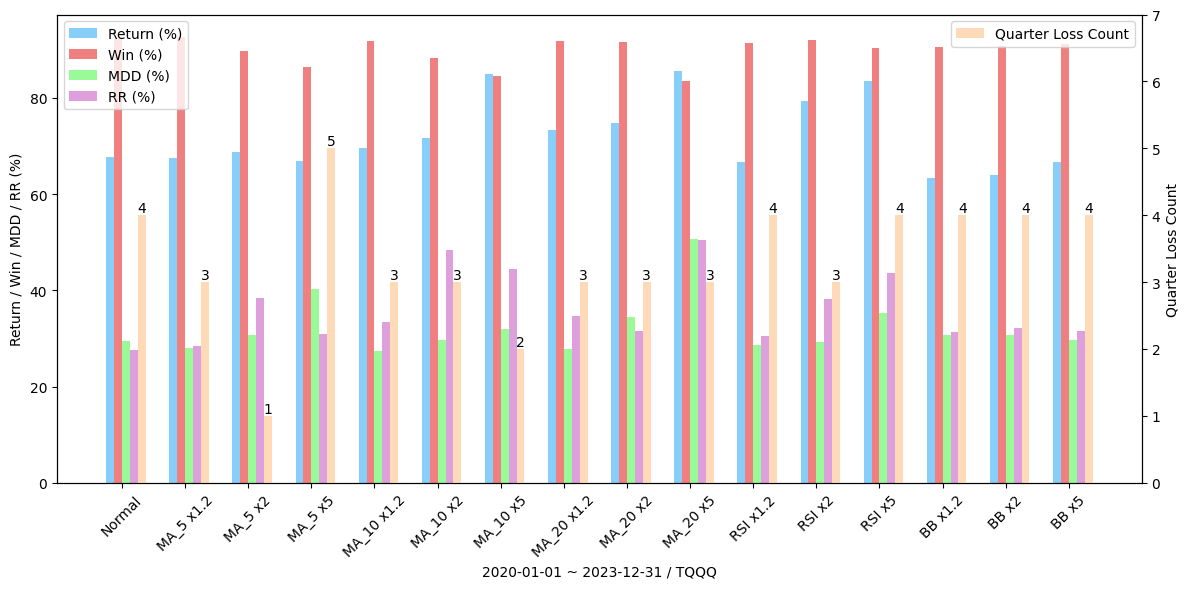

In [6]:
# 보조지표 : MA, RSI, BB(볼린저 밴드) / 다른 단어는 기본 무매법으로 작동
indicators = ['MA_5', 'MA_10', 'MA_20', 'RSI', 'BB']
rates = [1.2, 2, 5]
results = pd.DataFrame()

# 일반 무한매수법의 성능
results.loc['Normal', '수익률'] = normal.get_return()
results.loc['Normal', '승률'] = normal.get_winning_rate()
results.loc['Normal', '쿼터손절'] = normal.get_quarter_count()
results.loc['Normal', 'MDD'] = normal.get_MDD()
results.loc['Normal', 'RR'] = normal.get_RR()

for indicator in indicators:
    for rate in rates:
        index = indicator + ' x' + str(rate)

        strategy = InfiniteBuyStrategy(df=df, start_date=start_date, end_date=end_date, initial_funds=initial_funds, trend=indicator, rate=rate)
        strategy.run_backtest()
        results.loc[index, '수익률'] = strategy.get_return()
        results.loc[index, '승률'] = strategy.get_winning_rate()
        results.loc[index, '쿼터손절'] = int(strategy.get_quarter_count())
        results.loc[index, 'MDD'] = strategy.get_MDD()
        results.loc[index, 'RR'] = strategy.get_RR()

display(results)

# 추세 지표 + 배율 조정
plot_grouped_bar_scaled(results)

,수익률,승률,쿼터손절,MDD,RR
Normal,67.75,92.27,4.0,-29.37,27.52
MA_20 + ATR,87.65,88.38,3.0,-42.69,55.05
MA_20 + VIX,91.59,93.10,2.0,-27.26,43.61
RSI + ATR,73.43,90.64,3.0,-46.94,29.45
RSI + VIX,68.36,92.57,3.0,-34.08,26.18
BB + ATR,74.73,90.56,3.0,-49.31,32.40
BB + VIX,67.95,91.71,4.0,-29.82,30.77


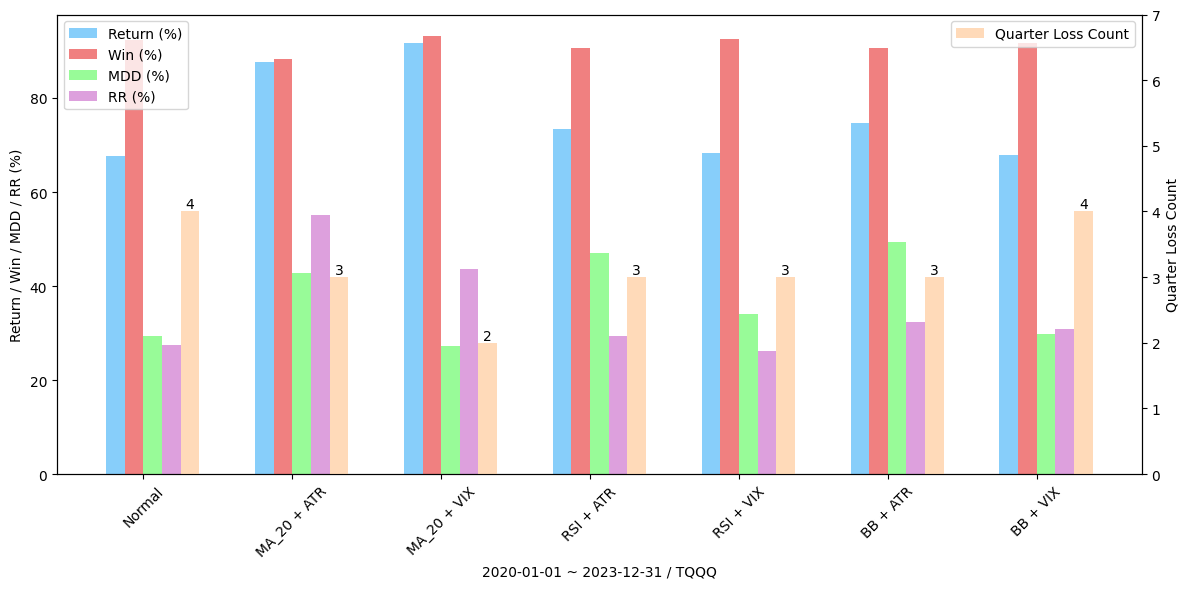

In [7]:
# 추세 + 변동성
trends = ['MA_20', 'RSI', 'BB']
volatilities = ['ATR', 'VIX']
results_volatility = pd.DataFrame()

# 일반 무한매수법의 성능
results_volatility.loc['Normal', '수익률'] = normal.get_return()
results_volatility.loc['Normal', '승률'] = normal.get_winning_rate()
results_volatility.loc['Normal', '쿼터손절'] = normal.get_quarter_count()
results_volatility.loc['Normal', 'MDD'] = normal.get_MDD()
results_volatility.loc['Normal', 'RR'] = normal.get_RR()

for trend in trends:
    for volatility in volatilities:
        index = trend + ' + ' + volatility

        strategy = InfiniteBuyStrategy(df=df, start_date=start_date, end_date=end_date, initial_funds=initial_funds, trend=trend, volatility=volatility, rate=2)
        strategy.run_backtest()
        results_volatility.loc[index, '수익률'] = strategy.get_return()
        results_volatility.loc[index, '승률'] = strategy.get_winning_rate()
        results_volatility.loc[index, '쿼터손절'] = int(strategy.get_quarter_count())
        results_volatility.loc[index, 'MDD'] = strategy.get_MDD()
        results_volatility.loc[index, 'RR'] = strategy.get_RR()

display(results_volatility)

# 추세 지표 + 변동성 지표
plot_grouped_bar_scaled(results_volatility)